In [1]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx

path_to_abca7 = '/home/gridsan/djuna/homer/github/ABCA7lof2'
import sys
sys.path.append(path_to_abca7)
from matplotlib.colors import SymLogNorm

from ABCA7lof2.geneclusters import get_scores, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite, plot_component, plot_edges, plot_nodes, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, compute_groupped_matrix, get_full_matrix_from_bipartite

In [2]:
scores = pd.read_csv('../processed_data/common_var/rs3752246_binary_scores.csv', index_col = 0)
scores.head()
scores.columns = ['Ex']
scores.head()

,Ex
POLR2E,4.948624
TADA1,4.336838
HSF1,-4.007025
TMEM259,-3.961947
BIN3,-3.665732


In [12]:
frame.head()

,Unnamed: 0,Var1,Var2,value
0,1,The citric acid (TCA) cycle and respiratory el...,1,SLC16A1
1,2,fatty acid beta-oxidation using acyl-CoA oxida...,1,ACOT8
2,3,Beta-oxidation of pristanoyl-CoA Homo sapiens ...,1,ACOXL
3,4,The citric acid (TCA) cycle and respiratory el...,2,PDHX
4,5,fatty acid beta-oxidation using acyl-CoA oxida...,2,ECI2


/state/partition1/slurm_tmp/24594260.0.0/ipykernel_2323993/496654884.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r', lut=20)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/state/partition1/slurm_tmp/24594260.0.0/ipykernel_2323993/496654884.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 1].set_yticklabels([f'${label.get_text()}$' for label in axes[i, 1].get_yticklabels()], fontstyle='italic')
/state/partition1/slurm_tmp/24594

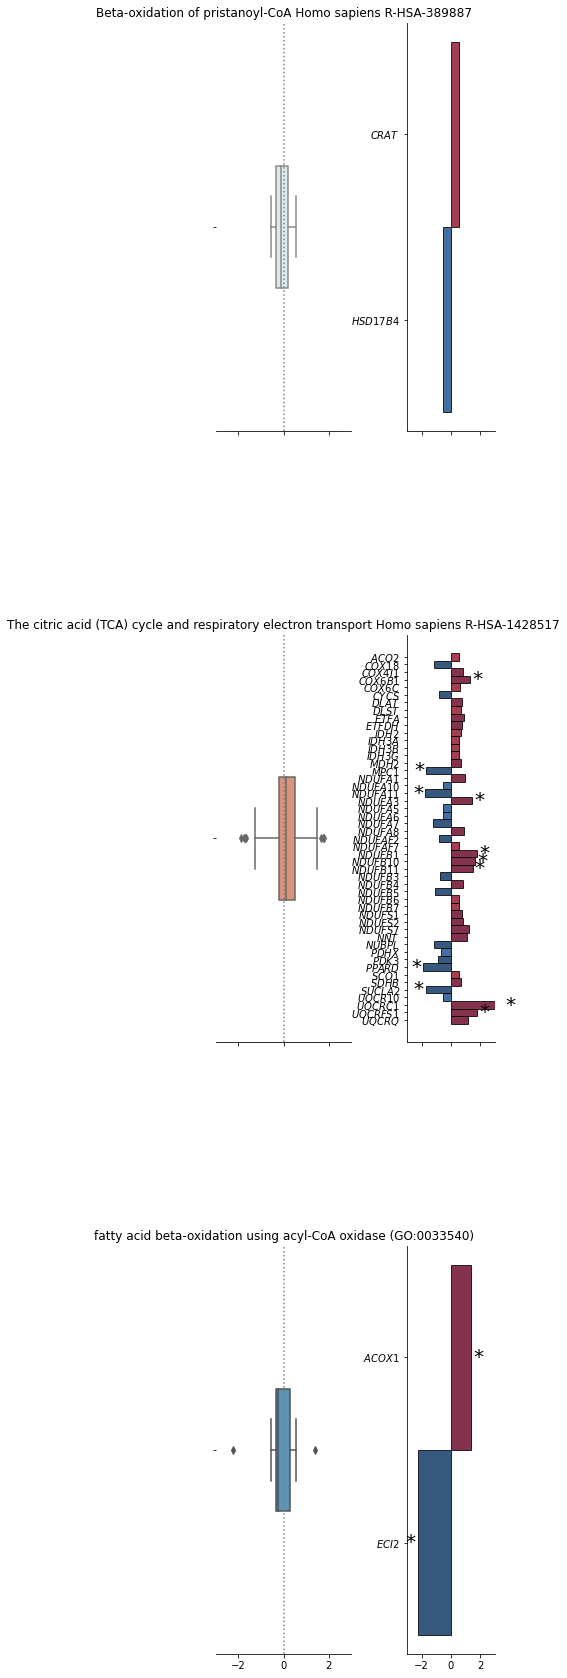

In [15]:
frame = pd.read_csv('../processed_data/common_var/lipid_ox_gset.csv')
#scores = pd.read_csv('../processed_data/single_cell/all_scores_0825.csv', index_col=0)
genes = set(scores.index)

unique_paths = np.unique(frame['grp'])

frame = frame.loc[[x in set(scores.index) for x in frame['value']]]

fig, axes = plt.subplots(len(unique_paths), 2, sharex=True, figsize=(5,30),gridspec_kw={'width_ratios': [2, 1.3]})
genes_used = set()

for i in range(len(unique_paths)):
    g_temp = np.unique(frame.loc[frame['grp']==unique_paths[i]]['value'])
    
    # Center the colormap at zero
    vmin = -1
    vmax = 1
    norm = SymLogNorm(linthresh=0.03, linscale=0.03, vmin=vmin, vmax=vmax)

    # Create a shifted colormap centered at zero
    cmap = plt.cm.get_cmap('RdBu_r', lut=20)
    
    x = np.array(scores.loc[np.array(g_temp)]['Ex'])
    x = x[x!=0]
    
    sns.boxplot(x,ax=axes[i,0], width=.3, color = cmap(norm(np.mean(x))));
    
    x = scores.loc[frame[frame['grp']==unique_paths[i]]['value']]
    x = x[np.abs(x['Ex'])>.5]
    df_reset = x.reset_index()

    df_reset = df_reset.loc[[x not in genes_used for x in df_reset['index']]]
    #bar_plot=sns.barplot(data = df_reset, y='index', x = 'Ex', ax=axes[i,1])
    

    df_reset = df_reset.sort_values(by='index', ascending=False)

    
    bar_plot=axes[i,1].barh(y=df_reset['index'], width =df_reset['Ex'], height=1, color=cmap(norm(df_reset['Ex'])), alpha=.8, edgecolor='black')

    # Add a star for values greater than 1.3
    for bar, value in zip(bar_plot, df_reset['Ex']):
        if abs(value) > 1.3:
            if value<0:
                p = -1
            else:
                p = 1
            axes[i, 1].text(value+(p*.5), bar.get_y() + bar.get_height() / 2, '*', ha='center', va='center', color='black', fontsize=20)

            
            
    g_temp = g_temp[np.array([x not in genes_used for x in g_temp])]
    genes_used.update(g_temp)

    axes[i,0].set_title(unique_paths[i])
    axes[i,0].axvline(0, color='grey', linestyle='dotted')
    
    axes[i, 1].set_yticklabels([f'${label.get_text()}$' for label in axes[i, 1].get_yticklabels()], fontstyle='italic')

    # Show borders along the top and right axes
    axes[i,0].spines['left'].set_visible(False)
    for ax in axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    axes[i,1].set_xlim(-3,3)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

#plt.savefig('../pdf_figures/lipid_synth_paths.pdf')

#### lipid synth genes

/state/partition1/slurm_tmp/24590389.0.0/ipykernel_1987852/2085134792.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r', lut=20)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/state/partition1/slurm_tmp/24590389.0.0/ipykernel_1987852/2085134792.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 1].set_yticklabels([f'${label.get_text()}$' for label in axes[i, 1].get_yticklabels()], fontstyle='italic')
/state/partition1/slurm_tmp/245

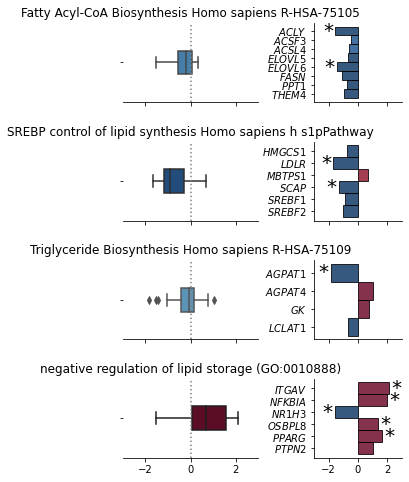

In [62]:
frame = pd.read_csv('../processed_data/common_var/lipid_synthesis_gsets.csv')
scores = pd.read_csv('../processed_data/single_cell/all_scores_0825.csv', index_col=0)
genes = set(scores.index)

unique_paths = np.unique(frame['grp'])

frame = frame.loc[[x in set(scores.index) for x in frame['value']]]

fig, axes = plt.subplots(len(unique_paths), 2, sharex=True, figsize=(5,8),gridspec_kw={'width_ratios': [2, 1.3]})
genes_used = set()

for i in range(len(unique_paths)):
    g_temp = np.unique(frame.loc[frame['grp']==unique_paths[i]]['value'])
    
    # Center the colormap at zero
    vmin = -1
    vmax = 1
    norm = SymLogNorm(linthresh=0.03, linscale=0.03, vmin=vmin, vmax=vmax)

    # Create a shifted colormap centered at zero
    cmap = plt.cm.get_cmap('RdBu_r', lut=20)
    
    x = np.array(scores.loc[np.array(g_temp)]['Ex'])
    x = x[x!=0]
    
    sns.boxplot(x,ax=axes[i,0], width=.3, color = cmap(norm(np.mean(x))));
    
    x = scores.loc[frame[frame['grp']==unique_paths[i]]['value']]
    x = x[np.abs(x['Ex'])>.5]
    df_reset = x.reset_index()

    df_reset = df_reset.loc[[x not in genes_used for x in df_reset['index']]]
    #bar_plot=sns.barplot(data = df_reset, y='index', x = 'Ex', ax=axes[i,1])
    

    df_reset = df_reset.sort_values(by='index', ascending=False)

    
    bar_plot=axes[i,1].barh(y=df_reset['index'], width =df_reset['Ex'], height=1, color=cmap(norm(df_reset['Ex'])), alpha=.8, edgecolor='black')

    # Add a star for values greater than 1.3
    for bar, value in zip(bar_plot, df_reset['Ex']):
        if abs(value) > 1.3:
            if value<0:
                p = -1
            else:
                p = 1
            axes[i, 1].text(value+(p*.5), bar.get_y() + bar.get_height() / 2, '*', ha='center', va='center', color='black', fontsize=20)

            
            
    g_temp = g_temp[np.array([x not in genes_used for x in g_temp])]
    genes_used.update(g_temp)

    axes[i,0].set_title(unique_paths[i])
    axes[i,0].axvline(0, color='grey', linestyle='dotted')
    
    axes[i, 1].set_yticklabels([f'${label.get_text()}$' for label in axes[i, 1].get_yticklabels()], fontstyle='italic')

    # Show borders along the top and right axes
    axes[i,0].spines['left'].set_visible(False)
    for ax in axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    axes[i,1].set_xlim(-3,3)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.savefig('../pdf_figures/lipid_synth_paths.pdf')

#### oxphos gset

array(['negative regulation of oxidative stress-induced neuron death (GO:1903204)',
       'negative regulation of response to reactive oxygen species (GO:1901032)',
       'positive regulation of reactive oxygen species metabolic process (GO:2000379)',
       'response to reactive oxygen species (GO:0000302)'], dtype=object)

/state/partition1/slurm_tmp/24625361.0.0/ipykernel_3358065/2327551292.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r', lut=20)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/state/partition1/slurm_tmp/24625361.0.0/ipykernel_3358065/2327551292.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[g].set_yticklabels([f'${label.get_text()}$' for label in axes[g].get_yticklabels()], fontstyle='italic')
/state/partition1/slurm_tmp/24625361.

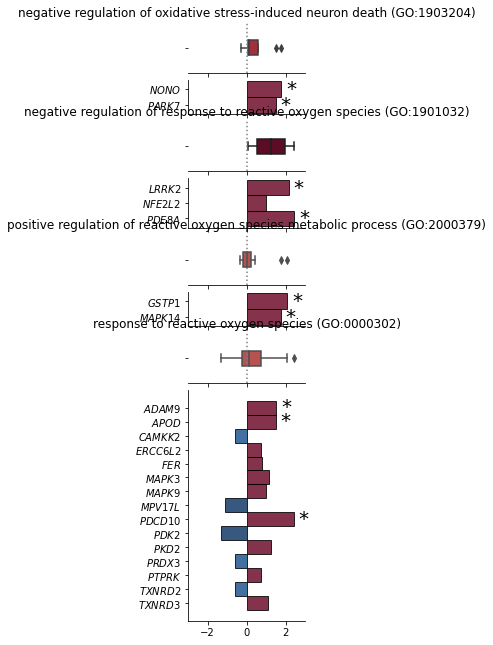

In [24]:
frame = pd.read_csv('../processed_data/common_var/ros_gset.csv')
scores = pd.read_csv('../processed_data/single_cell/all_scores_0825.csv', index_col=0)
genes = set(scores.index)

unique_paths = np.unique(frame['grp'])
unique_paths = unique_paths[[x not in [ 'regulation of oxidative stress-induced neuron intrinsic apoptotic signaling pathway (GO:1903376)'] for x in unique_paths]]
# unique_paths = unique_paths[::-1]
# unique_paths = unique_paths[:2]
frame = frame.loc[[x in set(scores.index) for x in frame['value']]]

fig, axes = plt.subplots(len(unique_paths)*2, 1, sharex=True, figsize=(2.1,11),gridspec_kw={ 'height_ratios': [1.3,.9,1.3, 1.3,1.3,.9,1.3,6]})
genes_used = set()

f = 0
g = 1

for i in range(len(unique_paths)):
    g_temp = np.unique(frame.loc[frame['grp']==unique_paths[i]]['value'])
    
    # Center the colormap at zero
    vmin = -1
    vmax = 1
    norm = SymLogNorm(linthresh=0.03, linscale=0.03, vmin=vmin, vmax=vmax)

    # Create a shifted colormap centered at zero
    cmap = plt.cm.get_cmap('RdBu_r', lut=20)
    
    x = np.array(scores.loc[np.array(g_temp)]['Ex'])
    x = x[x!=0]
    
    sns.boxplot(x,ax=axes[f], width=.3, color = cmap(norm(np.mean(x))));
    
    x = scores.loc[frame[frame['grp']==unique_paths[i]]['value']]
    x = x[np.abs(x['Ex'])>.5]
    df_reset = x.reset_index()

    df_reset = df_reset.loc[[x not in genes_used for x in df_reset['index']]]
    #bar_plot=sns.barplot(data = df_reset, y='index', x = 'Ex', ax=axes[i,1])
    

    df_reset_sorted = df_reset.sort_values(by='index', ascending=False)

    
    bar_plot=axes[g].barh(y=df_reset_sorted['index'], width =df_reset_sorted['Ex'], height=1, color=cmap(norm(df_reset_sorted['Ex'])), alpha=.8, edgecolor='black')

    # Add a star for values greater than 1.3
    for bar, value in zip(bar_plot, df_reset_sorted['Ex']):
        if abs(value) > 1.3:
            if value<0:
                p = -1
            else:
                p = 1
            axes[g].text(value+(p*.5), bar.get_y() + bar.get_height() / 2, '*', ha='center', va='center', color='black', fontsize=20)

            
            
    g_temp = g_temp[np.array([x not in genes_used for x in g_temp])]
    genes_used.update(g_temp)

    axes[f].set_title(unique_paths[i])
    axes[f].axvline(0, color='grey', linestyle='dotted')
    
    axes[g].set_yticklabels([f'${label.get_text()}$' for label in axes[g].get_yticklabels()], fontstyle='italic')

    # Show borders along the top and right axes
    axes[f].spines['left'].set_visible(False)
    for ax in axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    axes[g].set_xlim(-3,3)
    
    f+=2
    g+=2
plt.subplots_adjust(wspace=0.8, hspace=0.1)

#plt.savefig('../pdf_figures/ros_paths.pdf')

In [25]:
frame

,Unnamed: 0,value,grp
0,1,NUP93,negative regulation of response to reactive ox...
1,2,GPR37,negative regulation of response to reactive ox...
2,3,LRRK2,negative regulation of response to reactive ox...
3,4,GPR37L1,negative regulation of response to reactive ox...
5,6,TXN,negative regulation of response to reactive ox...
...,...,...,...
119,120,FBXW7,regulation of oxidative stress-induced neuron ...
120,121,NONO,regulation of oxidative stress-induced neuron ...
121,122,PARK7,regulation of oxidative stress-induced neuron ...
122,123,HIF1A,regulation of oxidative stress-induced neuron ...


#### ROS gset

/state/partition1/slurm_tmp/24622744.0.0/ipykernel_2563539/1704519284.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r', lut=20)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/state/partition1/slurm_tmp/24622744.0.0/ipykernel_2563539/1704519284.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([f'${label.get_text()}$' for label in axes[1].get_yticklabels()], fontstyle='italic')


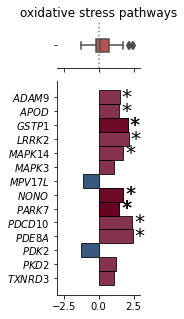

In [46]:
frame = pd.read_csv('../processed_data/common_var/ros_gset.csv')
scores = pd.read_csv('../processed_data/single_cell/all_scores_0825.csv', index_col=0)
genes = set(scores.index)

frame['grp']='oxidative stress pathways'
unique_paths = np.unique(frame['grp'])
#
#unique_paths = unique_paths[::-1]#[:2]
#unique_paths = unique_paths[:2]
frame = frame.loc[[x in set(scores.index) for x in frame['value']]]

fig, axes = plt.subplots(2,1, sharex=True, figsize=(1.5,5),gridspec_kw={'height_ratios': [.25,1.2]})
genes_used = set()

for i in range(len(unique_paths)):
    g_temp = np.unique(frame.loc[frame['grp']==unique_paths[i]]['value'])
    
    # Center the colormap at zero
    vmin = -1
    vmax = 1
    norm = SymLogNorm(linthresh=0.03, linscale=0.03, vmin=vmin, vmax=vmax)

    # Create a shifted colormap centered at zero
    cmap = plt.cm.get_cmap('RdBu_r', lut=20)
    
    x = np.array(scores.loc[np.array(g_temp)]['Ex'])
    x = x[x!=0]
    
    sns.boxplot(x,ax=axes[0], width=.3, color = cmap(norm(np.mean(x))));
    
    x = scores.loc[frame[frame['grp']==unique_paths[i]]['value']]
    x = x[np.abs(x['Ex'])>1]
    df_reset = x.reset_index()

    df_reset = df_reset.loc[[x not in genes_used for x in df_reset['index']]]
    #bar_plot=sns.barplot(data = df_reset, y='index', x = 'Ex', ax=axes[i,1])
    

    df_reset_sorted = df_reset.sort_values(by='index', ascending=False)

    
    bar_plot=axes[1].barh(y=df_reset_sorted['index'], width =df_reset_sorted['Ex'], height=1, color=cmap(norm(df_reset_sorted['Ex'])), alpha=.8, edgecolor='black')

    # Add a star for values greater than 1.3
    for bar, value in zip(bar_plot, df_reset_sorted['Ex']):
        if abs(value) > 1.3:
            if value<0:
                p = -1
            else:
                p = 1
            axes[1].text(value+(p*.5), bar.get_y() + bar.get_height() / 2, '*', ha='center', va='center', color='black', fontsize=20)

            
            
    g_temp = g_temp[np.array([x not in genes_used for x in g_temp])]
    genes_used.update(g_temp)

    axes[0].set_title(unique_paths[i])
    axes[0].axvline(0, color='grey', linestyle='dotted')
    
    axes[1].set_yticklabels([f'${label.get_text()}$' for label in axes[1].get_yticklabels()], fontstyle='italic')

    # Show borders along the top and right axes
    axes[0].spines['left'].set_visible(False)
    for ax in axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    axes[1].set_xlim(-3,3)
plt.subplots_adjust(wspace=0.8, hspace=0.1)

plt.savefig('../pdf_figures/ros_paths.pdf')

In [7]:
unique_paths

array(['negative regulation of oxidative stress-induced neuron death (GO:1903204)',
       'negative regulation of response to reactive oxygen species (GO:1901032)',
       'positive regulation of reactive oxygen species metabolic process (GO:2000379)',
       'regulation of oxidative stress-induced neuron intrinsic apoptotic signaling pathway (GO:1903376)',
       'response to reactive oxygen species (GO:0000302)'], dtype=object)

<Axes: xlabel='Ex', ylabel='index'>

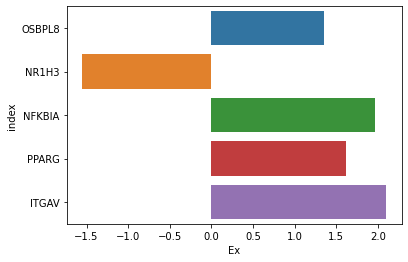

In [114]:
sns.barplot(data = df_reset, y='index', x = 'Ex')

In [ ]:
x

In [91]:
scores.loc['DGAT1']

Opc    0.228896
Ast    0.000000
Ex     0.186457
Oli    0.000000
Mic    0.000000
In    -0.035939
Name: DGAT1, dtype: float64